In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df = pd.read_csv(r'L:\Thesis\Exploratory-Analysis-of-Developer-Sentiment-on-Open-Source-Projects\Dataset\commits.csv')

In [3]:
repositories_of_interest = ['gecko-dev', 'hadoop', 'tomcat', 'lucene-solr', 'camel']

In [4]:
df=df[df['repo'].isin(repositories_of_interest)]

In [8]:
len(df)

1016723

C:\Users\User\AppData\Local\Temp\ipykernel_10088\2353165818.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regularity_indices = commits_per_day.groupby('committer').apply(calculate_regularity_index).reset_index()


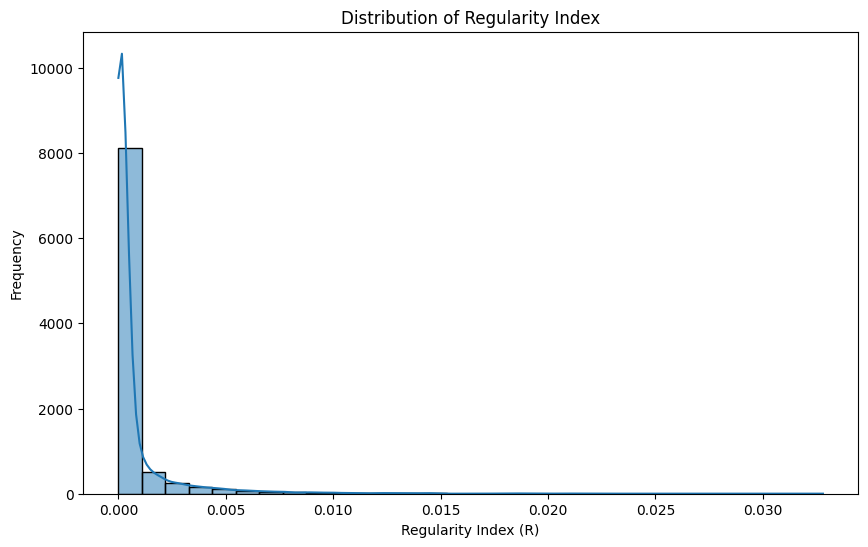

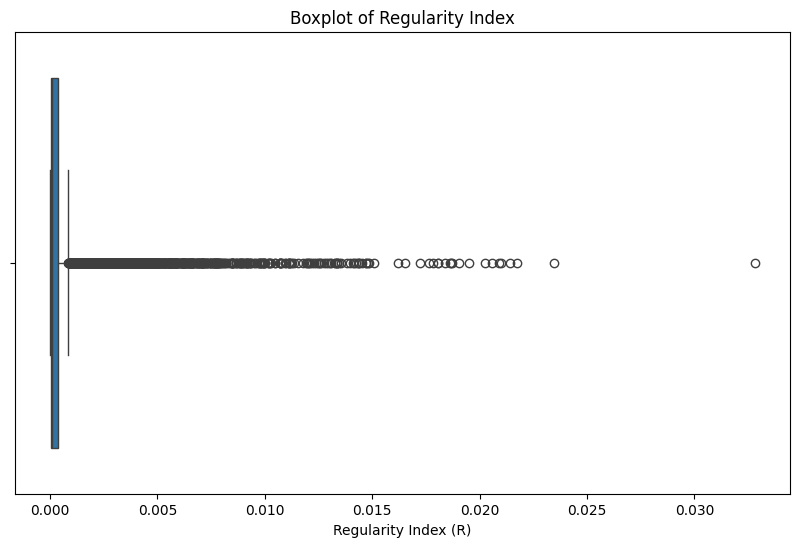

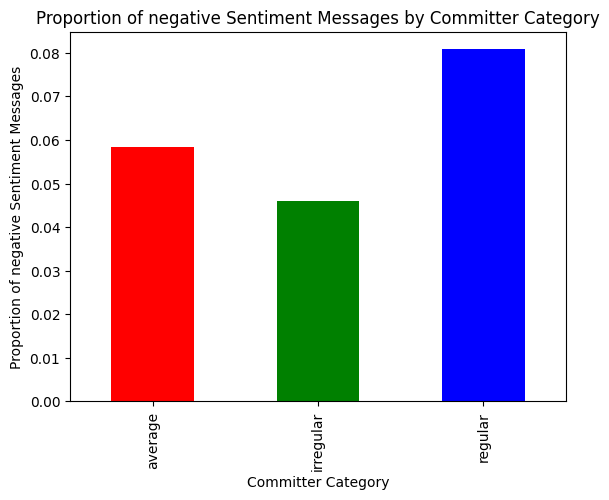

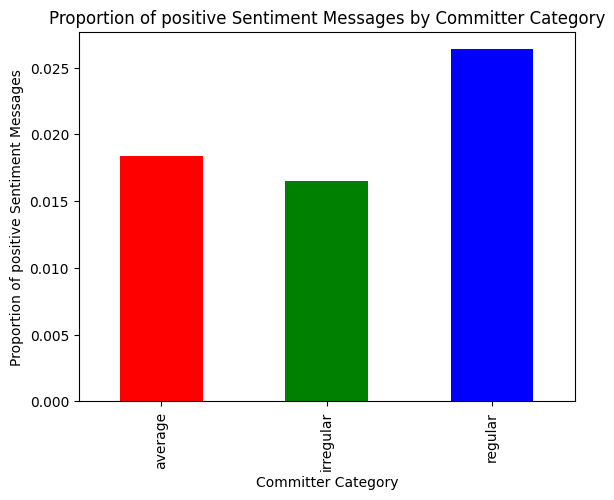

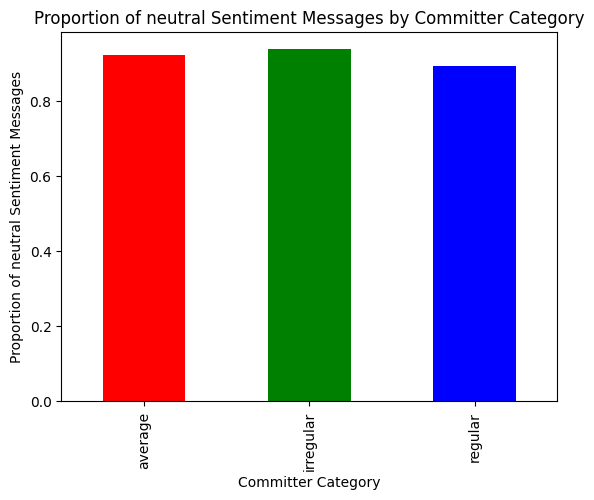

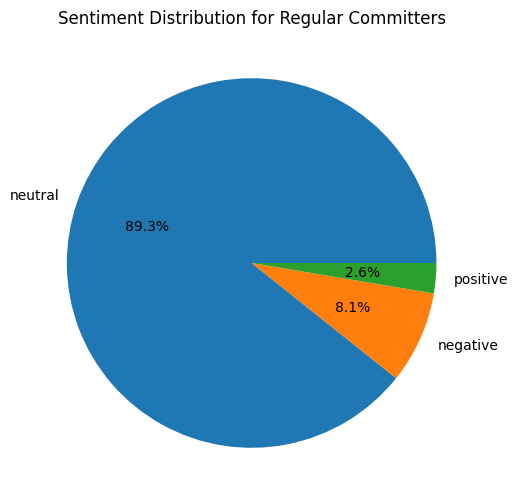

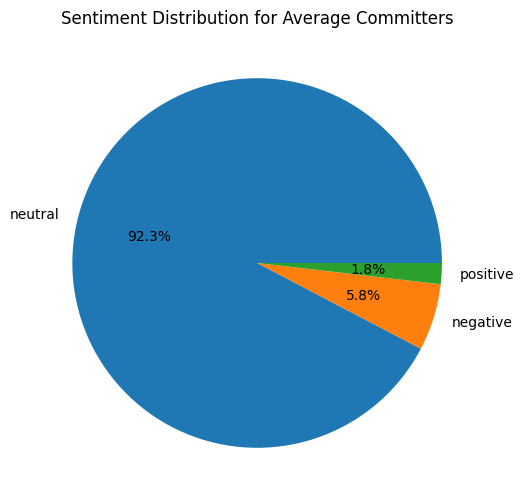

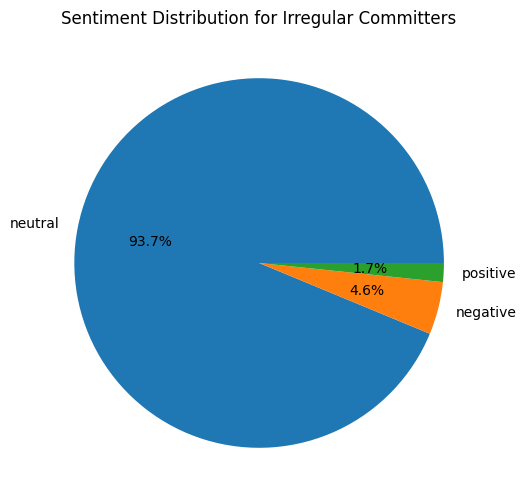

In [9]:


# Calculate the total number of days in the project
df['commit_time'] = pd.to_datetime(df['commit_time'])
D = (df['commit_time'].max() - df['commit_time'].min()).days + 1

# Calculate commits per day for each developer
df['commit_date'] = df['commit_time'].dt.date
commits_per_day = df.groupby(['committer', 'commit_date']).size().reset_index(name='commits')

# Calculate the regularity index R for each developer
def calculate_regularity_index(committer_data):
    di = committer_data['commit_date'].nunique()
    C = committer_data['commits'].sum()
    avg_commits_per_day = C / di
    commit_sd = np.sqrt((1/di) * np.sum((committer_data['commits'] - avg_commits_per_day)**2))
    R = (di / D) * (1 / (commit_sd + 1))
    return R, di, C

regularity_indices = commits_per_day.groupby('committer').apply(calculate_regularity_index).reset_index()
regularity_indices.columns = ['committer', 'regularity_data']
regularity_indices[['R', 'di', 'C']] = pd.DataFrame(regularity_indices['regularity_data'].tolist(), index=regularity_indices.index)
regularity_indices.drop(columns='regularity_data', inplace=True)

# Classify committers into regular, average, and irregular
Q1 = regularity_indices['R'].quantile(0.25)
Q3 = regularity_indices['R'].quantile(0.75)
IQR = Q3 - Q1

regularity_indices['category'] = 'average'
regularity_indices.loc[regularity_indices['R'] <= Q1, 'category'] = 'irregular'
regularity_indices.loc[regularity_indices['R'] >= Q3, 'category'] = 'regular'

# Merge with the original dataframe to get sentiments
df = df.merge(regularity_indices[['committer', 'category']], on='committer', how='left')

# Calculate the proportion of negative sentiment messages
negative_sentiment_counts = df[df['message_sentiment'] == 'negative'].groupby('category').size()
total_counts = df.groupby('category').size()
proportion_negative = negative_sentiment_counts/ total_counts

# Calculate the proportion of positive sentiment messages
positive_sentiment_counts = df[df['message_sentiment'] == 'positive'].groupby('category').size()
total_counts = df.groupby('category').size()
proportion_positive = positive_sentiment_counts/ total_counts


# Calculate the proportion of neutral sentiment messages
neutral_sentiment_counts = df[df['message_sentiment'] == 'neutral'].groupby('category').size()
total_counts = df.groupby('category').size()
proportion_neutral = neutral_sentiment_counts/ total_counts

# Plotting

# Distribution of Regularity Index
plt.figure(figsize=(10, 6))
sns.histplot(regularity_indices['R'], kde=True, bins=30)
plt.title('Distribution of Regularity Index')
plt.xlabel('Regularity Index (R)')
plt.ylabel('Frequency')
plt.show()

# Boxplot of Regularity Index
plt.figure(figsize=(10, 6))
sns.boxplot(x=regularity_indices['R'])
plt.title('Boxplot of Regularity Index')
plt.xlabel('Regularity Index (R)')
plt.show()

# Bar Plot of negative Sentiment Proportion
proportion_negative.plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Proportion of negative Sentiment Messages by Committer Category')
plt.xlabel('Committer Category')
plt.ylabel('Proportion of negative Sentiment Messages')
plt.show()

# Bar Plot of positive Sentiment Proportion
proportion_positive.plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Proportion of positive Sentiment Messages by Committer Category')
plt.xlabel('Committer Category')
plt.ylabel('Proportion of positive Sentiment Messages')
plt.show()

# Bar Plot of neutral Sentiment Proportion
proportion_neutral.plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Proportion of neutral Sentiment Messages by Committer Category')
plt.xlabel('Committer Category')
plt.ylabel('Proportion of neutral Sentiment Messages')
plt.show()




# Pie Chart of Sentiment Distribution
for category in df['category'].unique():
    plt.figure(figsize=(6, 6))
    df[df['category'] == category]['message_sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title(f'Sentiment Distribution for {category.capitalize()} Committers')
    plt.ylabel('')
    plt.show()



In [10]:
# Calculate the number of negative sentiments for irregular and regular committers
negative_sentiments_irregular = df[(df['category'] == 'irregular') & (df['message_sentiment'] == 'negative')].shape[0]
negative_sentiments_regular = df[(df['category'] == 'regular') & (df['message_sentiment'] == 'negative')].shape[0]

# Calculate the total number of sentiments for irregular and regular committers
total_sentiments_irregular = df[df['category'] == 'irregular'].shape[0]
total_sentiments_regular = df[df['category'] == 'regular'].shape[0]

# Proportions of negative sentiments
proportion_negative_irregular = negative_sentiments_irregular / total_sentiments_irregular
proportion_negative_regular = negative_sentiments_regular / total_sentiments_regular

# Perform two-proportion z-test
count = np.array([negative_sentiments_irregular, negative_sentiments_regular])
nobs = np.array([total_sentiments_irregular, total_sentiments_regular])

stat, p_value = proportions_ztest(count, nobs, alternative='larger')

print(f"Proportion of negative sentiment messages for irregular committers: {proportion_negative_irregular:.2f}")
print(f"Proportion of negative sentiment messages for regular committers: {proportion_negative_regular:.2f}")
print(f"Z-test statistic: {stat:.2f}")
print(f"p-value: {p_value:.4f}")

# Conclusion
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Irregular committers have a higher proportion of negative sentiment messages than regular committers.")
else:
    print("Fail to reject the null hypothesis: No significant evidence that irregular committers have a higher proportion of negative sentiment messages than regular committers.")


Proportion of negative sentiment messages for irregular committers: 0.05
Proportion of negative sentiment messages for regular committers: 0.08
Z-test statistic: -11.25
p-value: 1.0000
Fail to reject the null hypothesis: No significant evidence that irregular committers have a higher proportion of negative sentiment messages than regular committers.
